In [1]:
import data_utils
import model_utils
import plot_utils
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
def load_model(model_name, train, test, train_targ, test_targ):
    """
        Loaded previous train CNN model
    """
    print(model_name)
    new_model = keras.models.load_model("../outputs/model_checkpoint/model_checkpoint_%s.h5"%model_name)

    # -- feautres need to have an extra axis on the end (for mini-batching)
    feat_tr2 = train.reshape(len(train), train.shape[1], train.shape[2], 1)
    feat_te2 = test.reshape(len(test), test.shape[1], test.shape[2], 1)

    # -- print the accuracy
    loss_tr, acc_tr = new_model.evaluate(feat_tr2, train_targ, verbose=0)
    loss_te, acc_te = new_model.evaluate(feat_te2, test_targ, verbose=0)
        
    print("Training accuracy : {0:.4f}".format(acc_tr))
    print("Testing accuracy  : {0:.4f}".format(acc_te))

    return acc_tr, acc_te, new_model

In [3]:
def create_confusion_matrix(model_name, y_pred, targ):
    """
        Parameters
            - model_name: name of the model trained and specify which data is being predicted to create CM
            - y_pred: array with the probability prediction
        Returns
            - shows the confusion matrix plot

    """
    # -- confusion matrix for some data
    con_mat = tf.math.confusion_matrix(labels=targ, predictions=np.argmax(y_pred,axis=1)).numpy()
    con_mat.flatten()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1], 
                     columns = [0,1])
    con_mat_norm.flatten()
    labels = [f"{v1}\n{v2*100}%" for v1, v2 in
          zip(con_mat.flatten(),con_mat_norm.flatten())]
    labels = np.asarray(labels).reshape(2,2)
    categories = ["0: Real", "1: Bogus"]
    
    figure = plt.figure(figsize=(4, 5))
    sns.heatmap(con_mat, annot=labels,cbar=False,fmt='',xticklabels=categories,yticklabels=categories,cmap='Pastel2_r')#plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig("../outputs/confusion_matrix/more_data/confusionmatrix_model_more_data%s.pdf"%model_name,bbox_inches="tight")
    plt.show()
    
    return con_mat_df

In [4]:
def datas(df_tr, df_te, model_name):
    print(model_name)
    div = model_name.split("_")[1]
    if div[0:2] == "3D" or div[0:2] == "2D":
        data_location = "../data/data_split/"
    if div[0:2] == "n3" or div[0:2] == "n2":
        data_location = "../data/data_split_n/"
    if div[0:2] == "3s":
        data_location = "../data/data_split_3s/"
    print(data_location)
    #data_location = "../data/data_split_n/"                                                                                                                         
    if div[-3:] == "3DH":
        ddhs = 0
    if div[-3:] == "2DH":
        ddhs = 1

    train, test, train_targ, test_targ, train_ID, test_ID = data_utils.read_data_folders(data_location, 1,
                                                                          2000, ddh = ddhs)
    
    print(train.shape, test.shape)
    acc_tr, acc_te, model = load_model(model_name, train, test, train_targ, test_targ)
    df_pred_te, y_pred_te = model_utils.predict_data(test, model, 1, test_ID,test_targ)
    
    
    con_mat_df_te = create_confusion_matrix(model_name, y_pred_te, test_targ)
    
    return df_pred_te,con_mat_df_te,y_pred_te

CCC_3s2DH
../data/data_split_3s/
Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
(10, 51, 102) (20000, 51, 102)
CCC_3s2DH
Training accuracy : 0.8000
Testing accuracy  : 0.9155


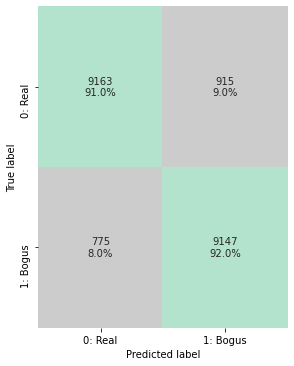

In [5]:
df_tr = pd.DataFrame()
df_te = pd.DataFrame()

df_te,con_mat_df_te, y_pred_test = datas(df_tr, df_te, "CCC_3s2DH")

In [6]:
df_te

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted
0,7956414,1,0.154537,0.845463,1
1,9152143,0,0.937056,0.062945,0
2,10595982,1,0.019109,0.980891,1
3,9482134,0,0.294298,0.705702,1
4,9238157,0,0.989753,0.010247,0
...,...,...,...,...,...
19995,8763685,1,0.016201,0.983799,1
19996,11377777,0,0.996489,0.003511,0
19997,9074085,1,0.006779,0.993221,1
19998,9398109,1,0.027539,0.972461,1


In [7]:
con_mat_df_te

,0,1
0,0.91,0.09
1,0.08,0.92


In [8]:
test_targ = df_te["OBJECT_TYPE"].to_numpy()
y_pred_test = df_te["predicted_float_Bogus"].to_numpy()

In [9]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_targ, y_pred_test)

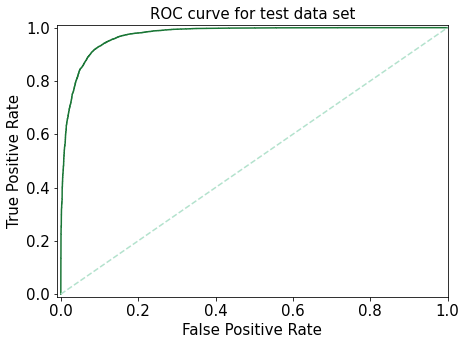

In [10]:
plt.subplots(1, figsize=(7,5))
plt.title('ROC curve for test data set',fontsize = 15)
plt.plot(false_positive_rate1, true_positive_rate1, color="#1a7636")
plt.plot([0, 1], ls="--", color = "#b3e2cd")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate',fontsize = 15)
plt.xlabel('False Positive Rate',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-0.01,1)
plt.ylim(-0.01,1.01)
# plt.savefig("ROC.pdf")
plt.show()

In [11]:
roc_auc_score(test_targ, y_pred_test)

0.9726427955876836

In [12]:
np.argmax(true_positive_rate1-false_positive_rate1) 

1475

In [13]:
threshold1[1520]

0.4974047

In [14]:
df_te["new_pred"] = [1 if i >= 0.4974047 else 0 for i in df_te["predicted_float_Bogus"] ]

In [15]:
df_te

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,new_pred
0,7956414,1,0.154537,0.845463,1,1
1,9152143,0,0.937056,0.062945,0,0
2,10595982,1,0.019109,0.980891,1,1
3,9482134,0,0.294298,0.705702,1,1
4,9238157,0,0.989753,0.010247,0,0
...,...,...,...,...,...,...
19995,8763685,1,0.016201,0.983799,1,1
19996,11377777,0,0.996489,0.003511,0,0
19997,9074085,1,0.006779,0.993221,1,1
19998,9398109,1,0.027539,0.972461,1,1


In [10]:
tf.math.confusion_matrix(labels=test_targ, predictions=df_te["new_pred"]).numpy()


KeyError: 'new_pred'

In [ ]:
con_mat = tf.math.confusion_matrix(labels=test_targ, predictions=df_te["new_pred"]).numpy()
con_mat.flatten()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                 index = [0,1], 
                 columns = [0,1])
con_mat_df

In [ ]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Pastel2')

In [ ]:
rgba = cmap(0.1,bytes=True)

In [ ]:
rgba

In [ ]:
#b3e2cd >> green Confusion
#40004b >> purple divergent
#1a7636 >> green divergent

AAAD_3s3DH
../data/data_split_3s/
Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
(10, 51, 153) (20000, 51, 153)
AAAD_3s3DH
Training accuracy : 0.6000
Testing accuracy  : 0.9590


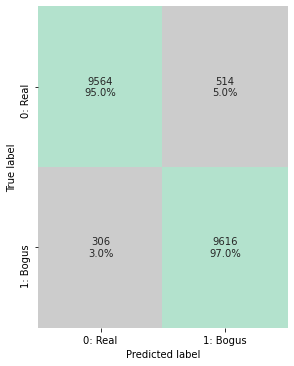

In [11]:
df_tr = pd.DataFrame()
df_te = pd.DataFrame()

df_te,con_mat_df_te, y_pred_test = datas(df_tr, df_te, "AAAD_3s3DH")

In [12]:
test_targ = df_te["OBJECT_TYPE"].to_numpy()
y_pred_test = df_te["predicted_float_Bogus"].to_numpy()

In [13]:
false_positive_rate, true_positive_rate, threshold = roc_curve(test_targ, y_pred_test)

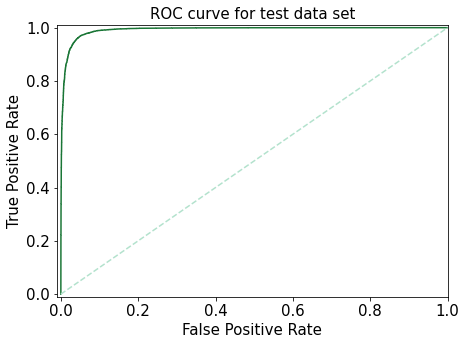

In [14]:
plt.subplots(1, figsize=(7,5))
plt.title('ROC curve for test data set',fontsize = 15)
plt.plot(false_positive_rate, true_positive_rate, color="#1a7636")
plt.plot([0, 1], ls="--", color = "#b3e2cd")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate',fontsize = 15)
plt.xlabel('False Positive Rate',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-0.01,1)
plt.ylim(-0.01,1.01)
# plt.savefig("ROC3D.pdf")
plt.show()

In [ ]:
roc_auc_score(test_targ, y_pred_test)

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  This is separate from the ipykernel package so we can avoid doing imports until


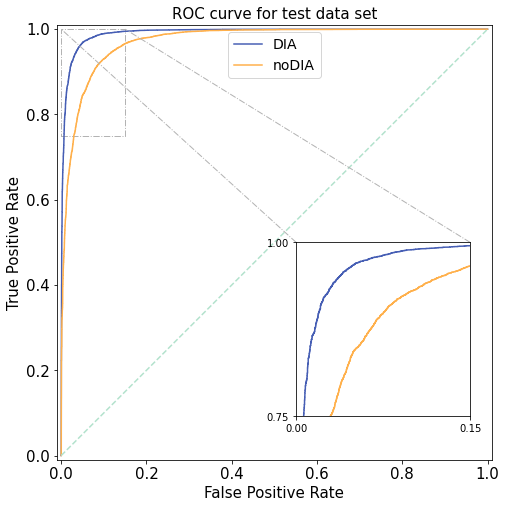

In [25]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.set_title('ROC curve for test data set',fontsize = 15)
ax.plot(false_positive_rate, true_positive_rate, color="#465eb4", label="DIA")
ax.plot(false_positive_rate1, true_positive_rate1, color="#ffb04b", label="noDIA")
ax.plot([0, 1], ls="--", color = "#b3e2cd")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
ax.set_ylabel('True Positive Rate',fontsize = 15)
ax.set_xlabel('False Positive Rate',fontsize = 15)
# ax.set_xticks(fontsize = 15)
# ax.set_yticks(fontsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
ax.set_aspect('equal', adjustable='box')
plt.legend(fontsize = 14, loc='upper center')

zax = zoomed_inset_axes(ax, 1, loc=2, axes_kwargs = {"box_aspect":1}, borderpad=2)
# zax.set_title('ROC curve for test data set',fontsize = 15)
# ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.5,0.1,0.5,0.4]) # last one is the relative size
zax.set_axes_locator(ip)
zax.plot(false_positive_rate, true_positive_rate, color="#465eb4", label="DIA")
zax.plot(false_positive_rate1, true_positive_rate1, color="#ffb04b", label="noDIA")
zax.plot([0, 1], ls="--", color = "#b3e2cd")
# zax.set_ylabel('True Positive Rate',fontsize = 15)
# zax.set_xlabel('False Positive Rate',fontsize = 15)
# zax.tick_params(axis = 'both', which = 'major', labelsize = 15)

zax.set_xlim((0.1, 0.15)); zax.set_xticks((0, 0.15))
zax.set_ylim((0.75, 1)) ; zax.set_yticks((0.75, 1))
zax.patch.set_alpha(0)
mark_inset(ax, zax, loc1=2, loc2=1, fc="none", ec="0.7", ls="-.")
# plt.show()
# plt.show()
plt.savefig("ROC_zoom.pdf")


In [156]:
mark_inset?

Signature: mark_inset(parent_axes, inset_axes, loc1, loc2, **kwargs)
Docstring:
Draw a box to mark the location of an area represented by an inset axes.

This function draws a box in *parent_axes* at the bounding box of
*inset_axes*, and shows a connection with the inset axes by drawing lines
at the corners, giving a "zoomed in" effect.

Parameters
----------
parent_axes : `matplotlib.axes.Axes`
    Axes which contains the area of the inset axes.

inset_axes : `matplotlib.axes.Axes`
    The inset axes.

loc1, loc2 : {1, 2, 3, 4}
    Corners to use for connecting the inset axes and the area in the
    parent axes.

**kwargs
    Patch properties for the lines and box drawn:

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
    alpha: float or None
    animated: bool
    antialiased or aa: unknown
    capstyle: {'butt', 'round', 'projecting'}
    clip_box: `.Bbox`
    clip_on: bool
    clip_path: Patch or

In [33]:
# now, create an inset axis, in the upper right corner, with
# a zoom factor of two


In [46]:
zoomed_inset_axes?

Signature:
zoomed_inset_axes(
    parent_axes,
    zoom,
    loc='upper right',
    bbox_to_anchor=None,
    bbox_transform=None,
    axes_class=None,
    axes_kwargs=None,
    borderpad=0.5,
)
Docstring:
Create an anchored inset axes by scaling a parent axes. For usage, also see
:doc:`the examples </gallery/axes_grid1/inset_locator_demo2>`.

Parameters
----------
parent_axes : `matplotlib.axes.Axes`
    Axes to place the inset axes.

zoom : float
    Scaling factor of the data axes. *zoom* > 1 will enlargen the
    coordinates (i.e., "zoomed in"), while *zoom* < 1 will shrink the
    coordinates (i.e., "zoomed out").

loc : int or str, default: 'upper right'
    Location to place the inset axes. The valid locations are::

        'upper right'  : 1,
        'upper left'   : 2,
        'lower left'   : 3,
        'lower right'  : 4,
        'right'        : 5,
        'center left'  : 6,
        'center right' : 7,
        'lower center' : 8,
        'upper center' : 9,
        'center

In [10]:
np.argmax(true_positive_rate1-false_positive_rate1) 

955

In [11]:
threshold1[955]

0.49511144